In [1]:
#!/usr/bin/env python
# coding: utf-8
# In[1]:
import os
# os.environ["PYTHONPATH"]="/custom"

import pandas as pd
import matplotlib.pyplot as plt

import g4ppyy as g4
from g4ppyy import mm, cm, m, eV, MeV, GeV, deg, twopi

import random

gRunManager = g4.G4RunManager();

class custom_generator(g4.G4VUserPrimaryGeneratorAction):
    "Moderated Cf252 Generator"
    def __init__(self):
        super().__init__()
        self.particle = g4.G4Neutron.Definition()
        self.particleGun = g4.G4ParticleGun()
        self.particleGun.SetParticleDefinition(self.particle)
        self.particleGun.SetParticleMomentumDirection(g4.G4ThreeVector(1, 0, 0))
        self.particleGun.SetNumberOfParticles(1)  
        self.particleGun.SetParticleTime(0)

    def GeneratePrimaries(self, anEvent):
        energy = 14 * MeV #beam_energy
        self.particleGun.SetParticlePosition(g4.G4ThreeVector(-40*cm,-1*cm + 5*cm*random.random(),-1*cm + 5*cm*random.random()))
        self.particleGun.SetParticleEnergy(energy)  
        self.particleGun.GeneratePrimaryVertex(anEvent)


# In [3]: NEUTRON DETECTOR
# Make a ND array to store information

class neutron_tracker(g4.G4VSensitiveDetector):

    def Reset(self):
        self.neutron_event = {
            "eid": [],
            "edep": [],
            "x": [],
            "y": [],
            "z": []        
        }
                
    def ProcessHits(self, aStep, ROhist):
        
        pdg = (aStep.GetTrack().GetParticleDefinition().GetPDGEncoding())
        if not (pdg == 2112): return 0

        eid = int(gRunManager.GetCurrentEvent().GetEventID())

        self.neutron_event["eid"].append( eid )
        
        pos = aStep.GetPreStepPoint().GetPosition() 
        dirs = aStep.GetTrack().GetMomentumDirection() 
        ek = aStep.GetPreStepPoint().GetTotalEnergy() 

        self.neutron_event["edep"].append(aStep.GetTotalEnergyDeposit())
        self.neutron_event["x"].append(pos.x())
        self.neutron_event["y"].append(pos.y())
        self.neutron_event["z"].append(pos.z())
        
        aStep.GetTrack().SetTrackStatus(g4.G4TrackStatus.fStopAndKill)

        return 1

    def StartOfRunAction(self):
        self.Reset()

    def EndOfRunAction(self):
        self.df = pd.DataFrame(data=self.neutron_event)

    def VisualizationAction(self):
        
        plt.scatter(self.df.x, self.df.y, c=self.df.edep)
        plt.title(str(self.GetName()) + " : XY Edep")
        plt.xlabel("x [mm]")
        plt.ylabel("z [mm]")
        plt.show()
        
        plt.scatter(self.df.x, self.df.z, c=self.df.edep)
        plt.title(str(self.GetName()) + " : XZ Edep")
        plt.xlabel("x [mm]")
        plt.xlabel("z [mm]")
        
        
        plt.show()
     
# In[3]:

class custom_world(g4.G4VUserDetectorConstruction):   
    def BuildMaterials(self):
        # Material definitions
        self.water_mat = g4.gNistManager.FindOrBuildMaterial("G4_WATER")

    def BuildWorld(self):
        # Mother Box
        self.world = g4.build_component("world", solid="box", x=5*m, y=5*m, z=5*m, material=self.water_mat)

        # World Geometries
        self.hdpe_outer = g4.build_component("shell", solid="tubs", rot=[90*deg, 0.0, 0.0], rmax=22*cm, z=1.2*m/2, mother=self.world, material="G4_POLYETHYLENE", color=[0.0,0.0,1.0,0.8], drawstyle="solid")
        self.water_inner = g4.build_component("water", solid="tubs", rmax=18*cm, z=1.2*m/2, mother=self.hdpe_outer, material="G4_WATER", color=[0.5,0.5,1.0,0.1], drawstyle="solid")
        self.hdpe_endcap1 = g4.build_component("cap1", solid="tubs", rmax=18*cm, z=1*cm, mother=self.water_inner, material="G4_POLYETHYLENE", color=[1.0,0.2,1.0,0.8], drawstyle="solid", pos=[0.0, 0.0, +1.2*m/2 - 1*cm])
        self.hdpe_endcap2 = g4.build_component("cap2", solid="tubs", rmax=18*cm, z=1*cm, mother=self.water_inner, material="G4_POLYETHYLENE", color=[1.0,0.2,1.0,0.8], drawstyle="solid", pos=[0.0, 0.0, -1.2*m/2 + 1*cm])

        self.hdpe_endcap3 = g4.build_component("cap3", solid="sphere", rmax=18*cm, z=1*cm, mother=self.world, material="G4_POLYETHYLENE", color=[1.0,0.1,1.0,0.8], drawstyle="solid", pos=[+2.0*m, 0.0, -1.2*m/2 + 1*cm])
        self.hdpe_endcap4 = g4.build_component("cap4", solid="box", x=30*cm, y=12*cm, z=10*cm, mother=self.world, material="G4_POLYETHYLENE", color=[1.0,1.0,0.1,0.8], drawstyle="solid", pos=[0.0*m, +1.0*m, -1.2*m/2 + 1*cm])

    
    def BuildDetectors(self):
        # Sensitive Volume Definitions
        self.hdpe_det = neutron_tracker("hdpe_det")
        self.world_det = neutron_tracker("world_det")
        
        self.world.GetLogicalVolume().SetSensitiveDetector(self.world_det)
        self.hdpe_outer.GetLogicalVolume().SetSensitiveDetector(self.hdpe_det)

        g4.register_detector_hooks(detector.hdpe_det)
        g4.register_detector_hooks(detector.world_det)

    def Construct(self):
        self.BuildMaterials()
        self.BuildWorld()
        self.BuildDetectors()
        
        # Return the mother
        return self.world # top mother volume



GEANT4 : Loading modules
GEANT4 : Loading complete.
GEANT4 : Imported all definitions.

**************************************************************
 Geant4 version Name: geant4-11-02-patch-02 [MT]   (21-June-2024)
                       Copyright : Geant4 Collaboration
                      References : NIM A 506 (2003), 250-303
                                 : IEEE-TNS 53 (2006), 270-278
                                 : NIM A 835 (2016), 186-225
                             WWW : http://geant4.org/
**************************************************************



<<< Geant4 Physics List simulation engine: QGSP_BERT

Available UI session types: [ tcsh, csh ]
### Adding tracking cuts for neutron  TimeCut(ns)= 10000  KinEnergyCut(MeV)= 0


/usr/local/lib/python3.9/site-packages/traittypes/traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "float32". A coerced copy has been created.
  warnings.warn(


Output()

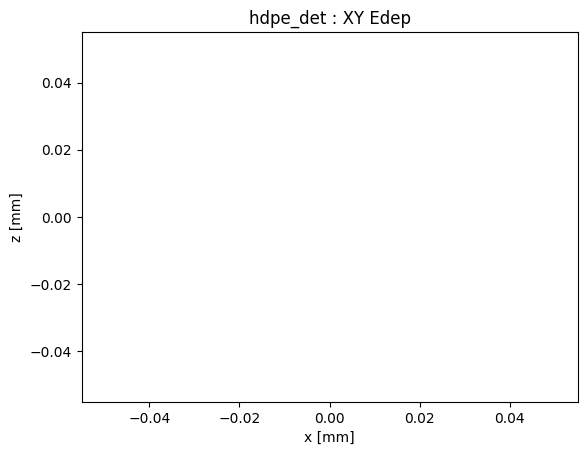

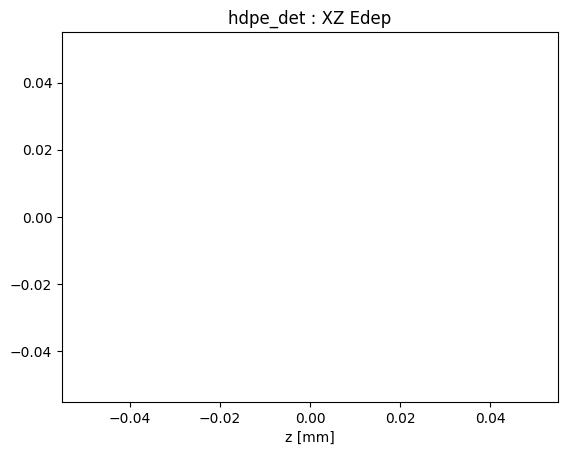

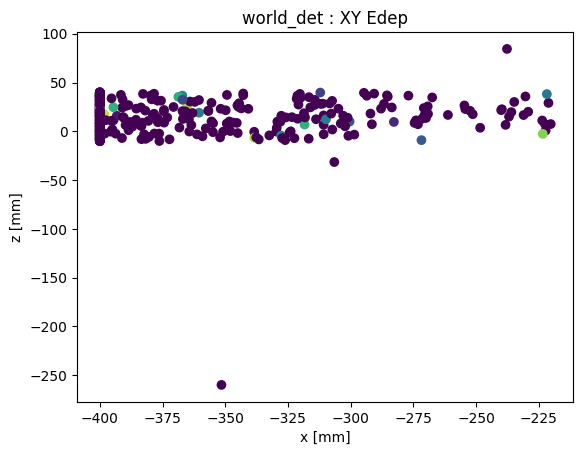

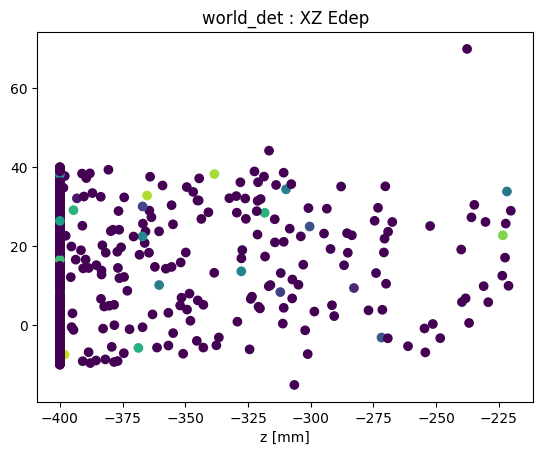

FINISHED


In [2]:
# In [4]:
# Add Physics List
physics = g4.QGSP_BERT()
gRunManager.SetUserInitialization(physics)

# Add a World
detector = custom_world()
gRunManager.SetUserInitialization(detector)

# Add a Generator
gen = custom_generator()
gRunManager.SetUserAction(gen)

# Add standard GEANT4 Actions
g4.add_default_actions(gRunManager)

# Setup vis to check geometry (optioonal)
g4.create_visualization(gRunManager)

# Generate some events
g4.handle_beam(gRunManager, 1000)

# Draw the vis plot (optional)
g4.draw_visualization(gRunManager)

print("FINISHED")